# Object Detection

In [1]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
twine 3.4.1 requires requests-toolbelt!=0.9.0,>=0.8.0, but you have requests-toolbelt 0.7.0 which is incompatible.
pyrebase 3.0.27 requires requests==2.11.1, but you have requests 2.25.1 which is incompatible.



  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=d97b4799357ce75b1ee1efa0cf6de256c8070d896830486559a7ef631b51aacf
  Stored in directory: c:\users\viksha\appdata\local\pip\cache\wheels\3a\ce\7a\27094f689461801c934296d07078773603663dfcaca63bb064
Successfully built clang
  Attempting uninstall: requests
    Found existing installation: requests 2.11.1
    Uninstalling requests-2.11.1:
      Successfully uninstalled requests-2.11.1
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [2]:
!pip install pycocotools

In [3]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [4]:
!pip install numpy
!pip install tensorflow-object-detection-api

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyrebase 3.0.27 requires requests==2.11.1, but you have requests 2.25.1 which is incompatible.
pyrebase 3.0.27 requires requests-toolbelt==0.7.0, but you have requests-toolbelt 0.9.1 which is incompatible.


In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

  Using cached requests_toolbelt-0.9.1-py2.py3-none-any.whl (54 kB)
  Attempting uninstall: requests-toolbelt
    Found existing installation: requests-toolbelt 0.7.0
    Uninstalling requests-toolbelt-0.7.0:
      Successfully uninstalled requests-toolbelt-0.7.0


In [6]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [7]:

utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

In [8]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [9]:

PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [10]:

PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('models/research/object_detection/test_images/image1.jpg'),
 WindowsPath('models/research/object_detection/test_images/image2.jpg'),
 WindowsPath('models/research/object_detection/test_images/image3.jpg'),
 WindowsPath('models/research/object_detection/test_images/image4.jpg'),
 WindowsPath('models/research/object_detection/test_images/image5.jpg'),
 WindowsPath('models/research/object_detection/test_images/image6.jpg')]

# Detection

In [11]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [13]:
detection_model.signatures['serving_default'].output_dtypes

{'detection_boxes': tf.float32,
 'detection_scores': tf.float32,
 'detection_classes': tf.float32,
 'num_detections': tf.float32}

In [14]:
detection_model.signatures['serving_default'].output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_scores': TensorShape([None, 100]),
 'detection_classes': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [15]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
 
  input_tensor = tf.convert_to_tensor(image)

  input_tensor = input_tensor[tf.newaxis,...]

 
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

 
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections


  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   

  if 'detection_masks' in output_dict:
  
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [16]:
def show_inference(model, image_path):

  image_np = np.array(Image.open(image_path))
 
  output_dict = run_inference_for_single_image(model, image_np)

  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

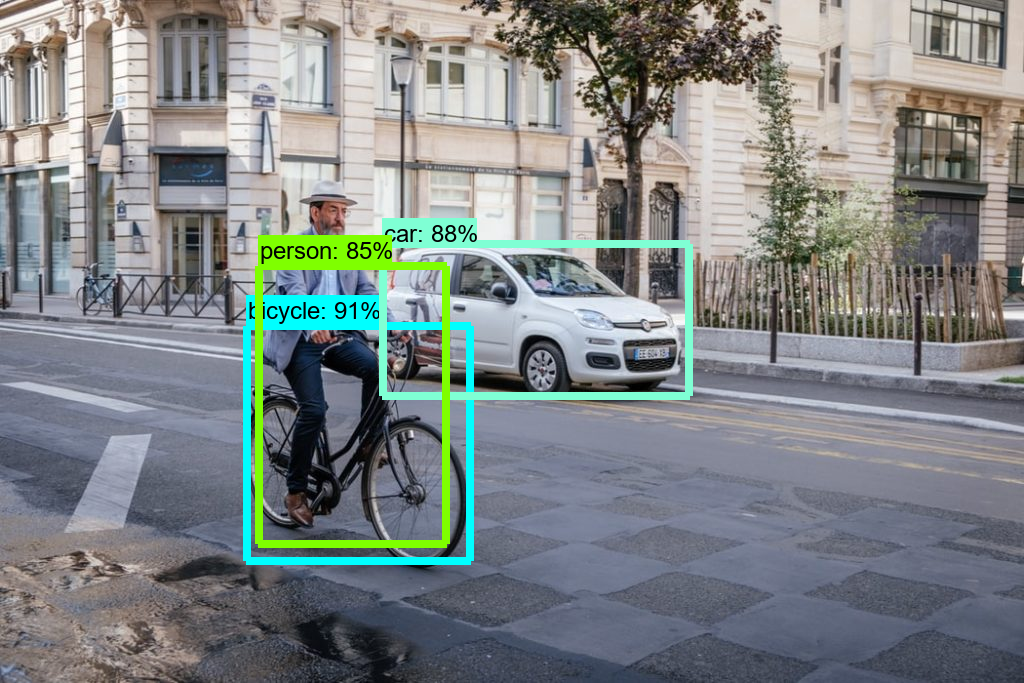

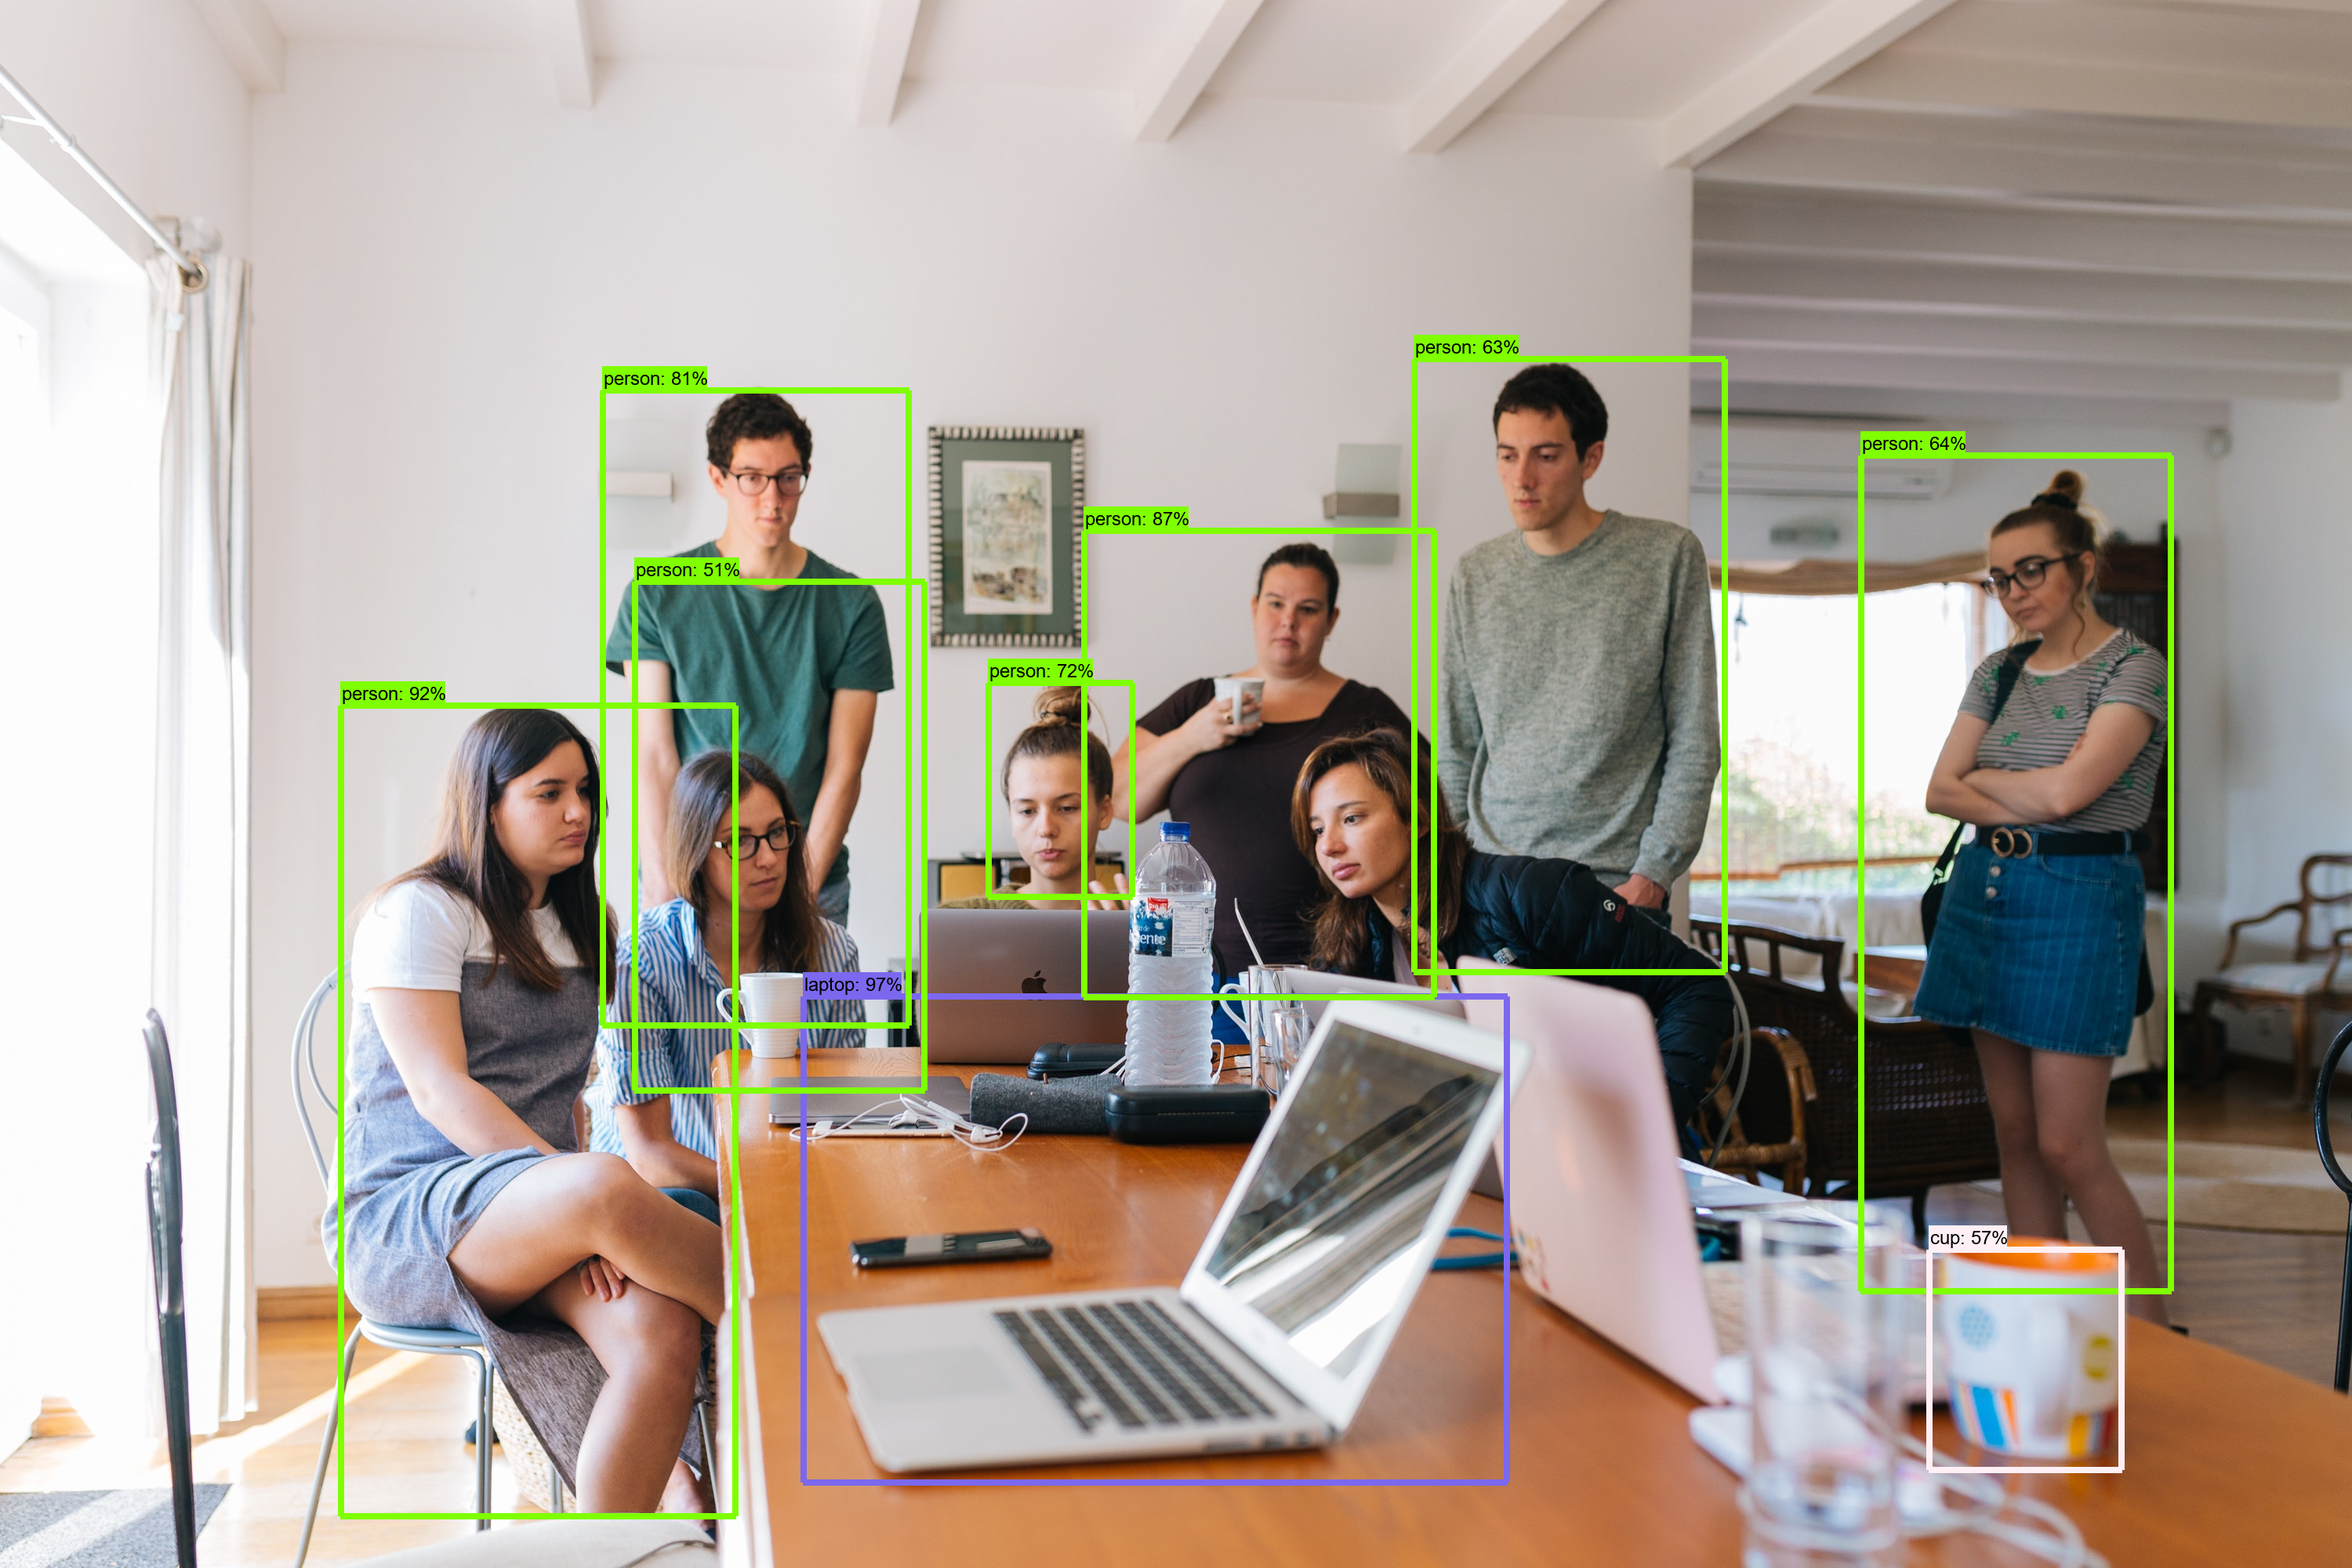

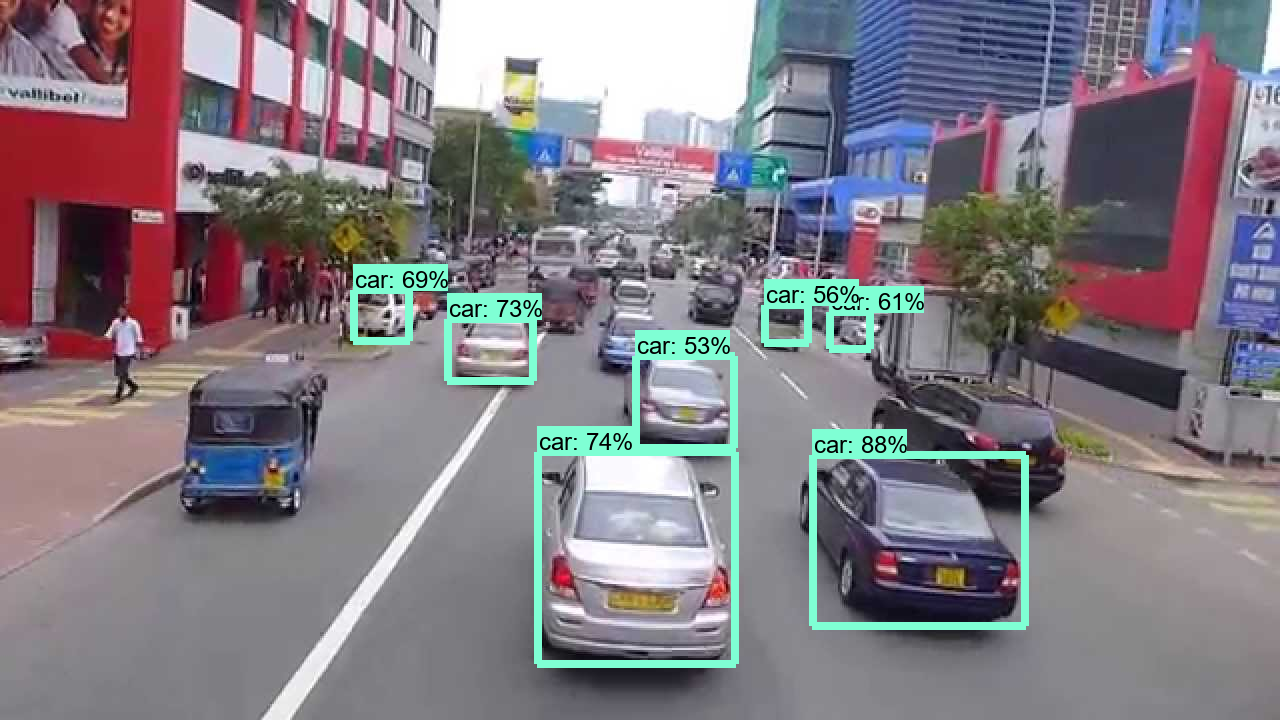

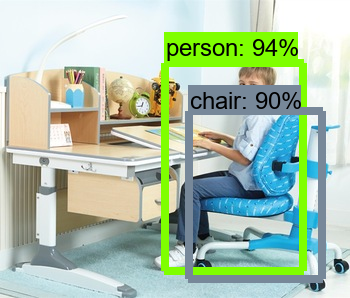

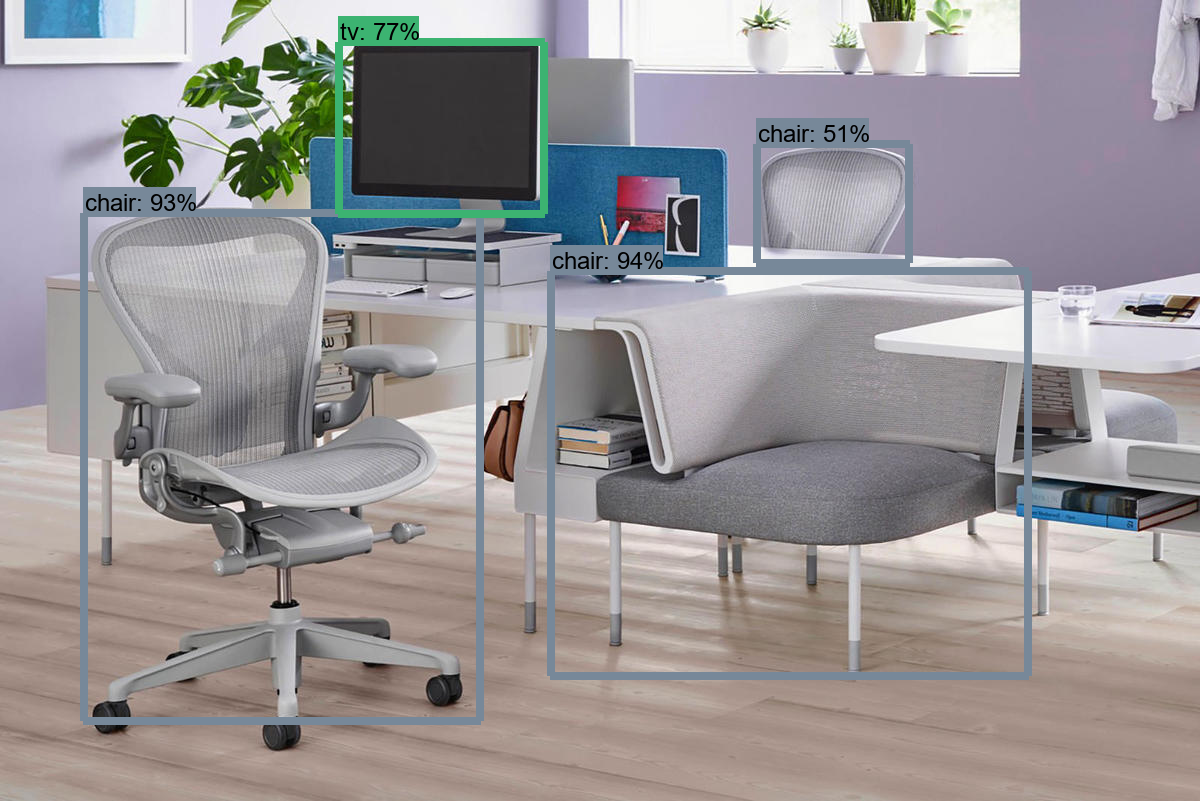

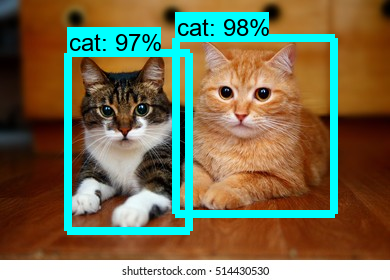

In [17]:

for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)